# Text modeling

## Lecture plan

- Modeling the *contents* of text.  
- [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf): a (relatively) simple approach.  
   - Basic premises of tf-idf.
- Applying *tf-idf* in Python.
- A brief tour of other methods.

## Load libraries

In [21]:
import numpy as np
from scipy.spatial.distance import cosine

import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

## Building models of text

> Building a model of the **contents** of a text document involves figuring out "what it's about". 

- Common use case in NLP.  
- Various techniques and approaches:
   - [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
   - [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis)
   - And much more!

### What are these models good for?

- [Information retrieval](https://en.wikipedia.org/wiki/Information_retrieval).
   - Given a *search query* and some set of *documents*, which documents are most relevant?
- [Document classification](https://en.wikipedia.org/wiki/Document_classification). 
   - Given a bunch of *documents*, what are their *categories*?
- [Keyword extraction](https://monkeylearn.com/keyword-extraction/).  
   - What are relevant *tags* or *keywords* to describe a document?  
- [Summarization](https://en.wikipedia.org/wiki/Automatic_summarization).  
   - Given a *document*, can we produce a readable *summary* of that document?
   
And much more.

### A long history of *models*

- NLP practitioners have been building models of text for decades.  
   - Even **sentiment analysis** counts as a model of text.
- In recent years, text modeling has improved considerably.
   - 2013: [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) like *word2vec* are introduced.  
   - 2017: [transformer](https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)) architecture is introduced.
   - 2022: [ChatGPT](https://chat.openai.com/) is released.
- We'll start with [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Example_of_tf%E2%80%93idf), a conceptual precursor to those more advanced methods.

## Introducing *tf-idf*

> [*Tf-idf*](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Example_of_tf%E2%80%93idf), or **term frequency, inverse document frequency** is a technique for measuring how important a word is to a given document or corpus, adjusted for overall frequency.

### Basic premises

What's a document *about*?

- The contents of a document are in some sense the *words* that appear in it.  
- Documents with more similar *words* are, on average, about more similar things.
   - In Linguistics, this is known as the [distributional hypothesis](https://en.wikipedia.org/wiki/Distributional_semantics).  
- A "model" of a document is the **count vector** of all the words that appear in it. 
- Some words are just more frequent overall, so we should **adjust** for that.

### Before tf-idf: count vectors

> A **count vector** is a *vector* (list) indicating the number of times each word $w$ in a vocabulary occurs in some document $d$.
  
![Optional Caption](img/vector.png)

### Documents as *vectors*, similarity as *proximity*

> In **vector semantics**, the **cosine distance** between two document vectors can be used as a proxy for how similar those documents are. 

$\Large cosine(v, w) = \frac{v \cdot w}{|v||w|}$

- $v \cdot w$: *dot product* between $v$ and $w$.  
- $|v||w|$: size of $v$ and $w$. 

In [23]:
### Very close vectors
v1 = np.array([1, 2, 5, 6])
v2 = np.array([2, 3, 4, 7])
cosine(v1, v2)  ### imported from scipy.spatial.distance

0.024384321658394104

#### Check-in

Try to create two vectors with a larger `cosine` distance.

In [24]:
### Your code here

#### Distant vectors

- Vectors will be more *distant* if they have more *orthogonal* elements, i.e., they are uncorrelated. 

In [25]:
### Very close vectors
v1 = np.array([1, 2, 5, 6])
v2 = np.array([6, 0, 0, 1])
cosine(v1, v2)  ### imported from scipy.spatial.distance

0.7571666024450942

### Count vectors in Python (1)

- We can use the `CountVectorizer` class to create a count matrix for a bunch of documents.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [27]:
# Sample documents
documents = [
    'the sky is blue',
    'the sun is bright',
    'the sun in the sky is bright',
    'we can see the shining sun, the bright sun'
]

### Count vectors in Python (2)

- We call `vectorizer.fit_transformer` on our documents.
- Then we convert that matrix to a `DataFrame`.

In [28]:
# Create a CountVectorizer object
vectorizer = CountVectorizer()
# Fit and transform the documents
count_matrix = vectorizer.fit_transform(documents)
count_matrix

<4x11 sparse matrix of type '<class 'numpy.int64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [29]:
# Convert the matrix to an array and label the columns and rows
count_array = count_matrix.toarray()
df = pd.DataFrame(count_array, columns=vectorizer.get_feature_names_out(), 
                  index=[f"Document {i+1}" for i in range(len(documents))])
print(df)

            blue  bright  can  in  is  see  shining  sky  sun  the  we
Document 1     1       0    0   0   1    0        0    1    0    1   0
Document 2     0       1    0   0   1    0        0    0    1    1   0
Document 3     0       1    0   1   1    0        0    1    1    2   0
Document 4     0       1    1   0   0    1        1    0    2    2   1


### Count vectors in Python (3)

- Finally, we can compute the *cosine distance* between our documents.

In [30]:
### Distance between doc 1 and doc 2
cosine(df.loc['Document 1'], df.loc['Document 2'])

0.5

In [31]:
### Distance between doc 1 and doc 3
cosine(df.loc['Document 1'], df.loc['Document 3'])

0.33333333333333326

In [32]:
### Distance between doc 2 and doc 3
cosine(df.loc['Document 2'], df.loc['Document 3'])

0.16666666666666663

### The problem with *counts*

- Some words are simply more **frequent overall**. 
- Using the *raw counts* of words does not control for the **uniqueness** of a given word to a given document.
   - E.g., "the" is extremely frequent, but doesn't tell us much about what a document is about.  
- Ideally, we'd have a way to calculate which words **uniquely co-occur**.

## tf-idf: a potential solution

> In [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Motivations), we compare the frequency of a word in a given document (**term frequency**) to the inverse frequency of that term across all documents (**inverse document frequency**). 

- $tf(t, d)$: *count* of term $t$ in document $d$.  
   - Just like our `CountVectorizer` before.
- $idf(t, D)$: how often does $t$ appear across all documents $D$?
   - This is a new term!

### Understanding inverse document frequency

> **Inverse document frequency** is measured in various different ways, but is meant to capture the *uniqueness* of a term to particular documents.

$\Large idf(t, D) = log(\frac{N}{df_t})$

- Where $N$ is the number of documents overall.  
- And $df_t$ is the number of documents in which $t$ occurs.

#### Check-in

How will inverse document frequency change as a term occurs across more or less documents?

In [33]:
### Your code here

#### Solution

In [34]:
### range of df_t values
df_t = np.arange(1, 101)
### Number of documents
N = 100
### idf

idf_t = np.log(N/df_t)

Text(0, 0.5, 'Inverse document frequency')

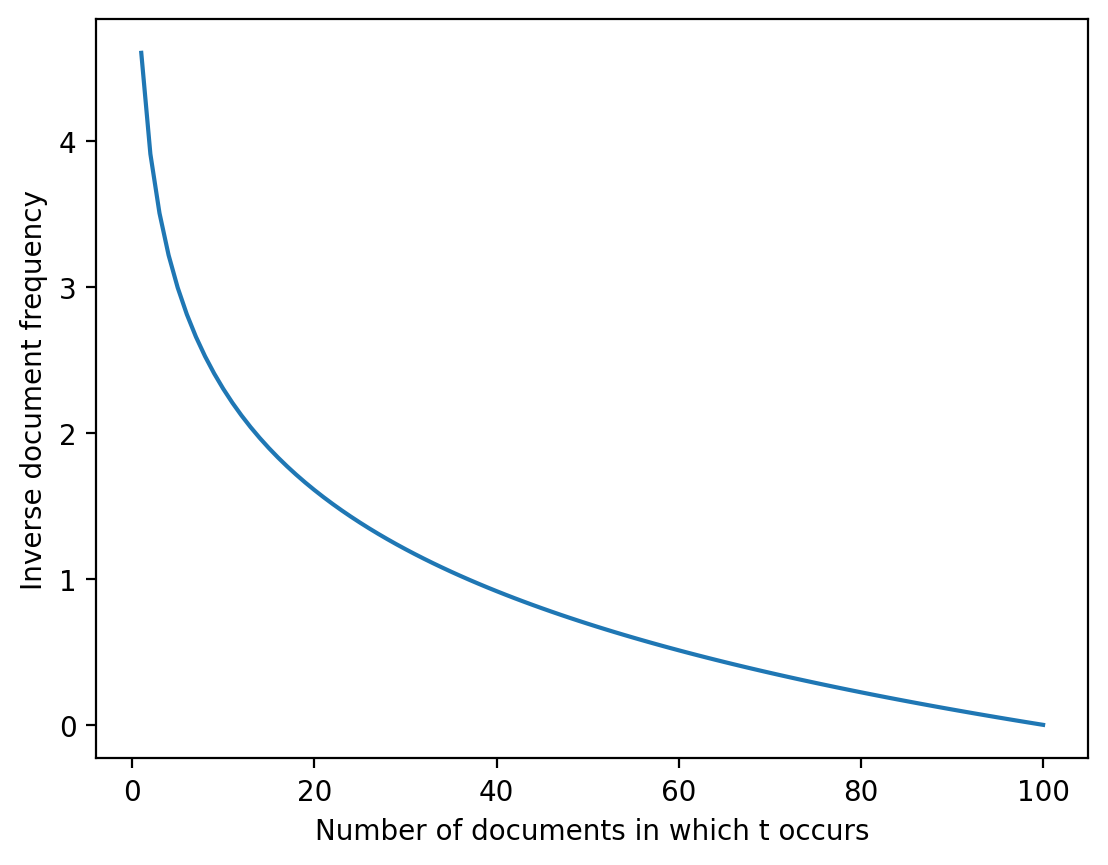

In [35]:
sns.lineplot(x = df_t, y = idf_t)
plt.xlabel("Number of documents in which t occurs")
plt.ylabel("Inverse document frequency")

### tf-idf: final explanation

- Again: basic premise is that we can *compare* documents based on whether they have similar words. 
- But some words are more **frequent**, so we control for those overall term frequencies.  
  - Common words like "the" and "good" will not *contribute* as much to the **representation** of a document.  
  - Less common words will make a bigger **impact**.

So how would this work in practice?

### tf-idf in Python (1)

- Syntactically, looks very similar to `CountVectorizer`!

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
# Sample documents
documents = [
    'the sky is blue',
    'the sun is bright',
    'the sun in the sky is bright',
    'we can see the shining sun, the bright sun'
]

### tf-idf in Python (2)

In [38]:
# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()
# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(documents)
# Get the feature names
feature_names = vectorizer.get_feature_names_out()

In [39]:
# Display the matrix
import pandas as pd
df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
print(df)

       blue    bright       can        in        is       see   shining  \
0  0.659191  0.000000  0.000000  0.000000  0.420753  0.000000  0.000000   
1  0.000000  0.522109  0.000000  0.000000  0.522109  0.000000  0.000000   
2  0.000000  0.321846  0.000000  0.504235  0.321846  0.000000  0.000000   
3  0.000000  0.239102  0.374599  0.000000  0.000000  0.374599  0.374599   

        sky       sun       the        we  
0  0.519714  0.000000  0.343993  0.000000  
1  0.000000  0.522109  0.426858  0.000000  
2  0.397544  0.321846  0.526261  0.000000  
3  0.000000  0.478204  0.390963  0.374599  


### tf-idf in Python (3)

- Now we can compare our documents.

In [40]:
### Distance between doc 1 and doc 2
cosine(df.loc[0], df.loc[1])

0.63348486857333

In [41]:
### Distance between doc 1 and doc 3
cosine(df.loc[0], df.loc[2])

0.476942561629634

In [42]:
### Distance between doc 2 and doc 3
cosine(df.loc[1], df.loc[2])

0.27124492054006366

## tf-idf, applied

- It's hard to see the *benefits* of *tf-idf* in such a small corpus of documents. 
- Let's look at a larger sample.  
- This will also allow us to see how *tf-idf* can be used for **text classification**.

### Step 1: load our dataset

- Let's use the *news groups* dataset from `sklearn`.

In [43]:
from sklearn.datasets import fetch_20newsgroups

In [44]:
# Load the 20 Newsgroups dataset
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Accessing the data
documents = newsgroups_data.data
categories = newsgroups_data.target

In [45]:
### A little under 20K documents
len(documents)

18846

In [69]:
### Example of some categories
newsgroups_data.target_names[0:4]

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware']

### Step 2: Use `TfidfVectorizer`

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=2, max_features=None)

In [49]:
# Fit and transform our data
X = vectorizer.fit_transform(documents)

### Step 2b: Checking our learned feature names

- Now, our `feature_names` is a *much longer vector*.
- It's *every word* in our corpus.

In [52]:
# Get the feature names
feature_names = vectorizer.get_feature_names_out()
len(feature_names)

51840

In [59]:
# Random sample
feature_names[10000:10010]

array(['boulders', 'boulevard', 'bounce', 'bounced', 'bounces',
       'bouncing', 'bound', 'boundaries', 'boundary', 'bounded'],
      dtype=object)

### Step 3: Train a classifier

- We can use these as **features** to train a classifier to predict the *category* of an article.

In [60]:
from sklearn.linear_model import LogisticRegression

In [61]:
# Initialize the classifier
clf = LogisticRegression(random_state=42, max_iter=1000)

In [62]:
# Train the classifier
clf.fit(X, categories)

LogisticRegression(max_iter=1000, random_state=42)

### Step 4: Evaluate the classifier

- Using these **learned features**, how accurately can we predict the category of a piece of text?

In [63]:
from sklearn.metrics import accuracy_score, classification_report

In [65]:
# Predict the labels for the test set
predictions = clf.predict(X)

In [70]:
# Accuracy score
accuracy = accuracy_score(categories, predictions)
print(f"Classification accuracy: {accuracy:.4f}")

Classification accuracy: 0.8972


#### Check-in

Our accuracy was pretty high. But was there anything we should've done *differently* in how we fit our `TfidfVectorizer` and our `LogisticRegression` model?

In [71]:
### Your answer here

### The importance of cross-validation

- Ordinarily, we would do a **train-test split**.  
  - I skipped that for this demonstration, because there was already enough going on!
- But a train-test split important is important both for:
  - Fitting our *classifier*: train on some documents, test on others.  
  - Learning our `TfidfVectorizer` features: `.fit_transform` on train set, `transform` test set.
- Critical for avoiding **data leakage**.

### tf-idf: wrap-up

- Tf-idf is an approach to **modeling** the contents of text.  
  - Gives us **features** to represent our text with.
- In combination with other approaches (e.g., **classification**), this is really powerful.  
- When we cover more advanced **machine learning** methods, these *applications* will make even more sense.

## Modeling text: a very brief tour

- tf-idf is certainly not the only game in town; these days it's not used as frequently.  
- Other approaches worth knowing about if you go into NLP.
   - [Latent semantic analysis (LSA)](https://en.wikipedia.org/wiki/Latent_semantic_analysis).
   - [Latent Dirichlet allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). 
   - [Word embeddings](https://en.wikipedia.org/wiki/Word_embedding). 
- Many of these other approaches improve upon tf-idf by discovering **latent "topics" or "dimensions"** among the term-document matrix.
- Some of these topics will be discussed later in the quarter, when we cover **deep learning**. 

## Lecture wrap-up

- Building **models** of text is a common use case in NLP and CSS.
   - Helpful for retrieval, classification, and more. 
- One simple approach is to represent documents as the **words** they contain.
- Tf-idf does that, and **normalizes** for the frequency of words across all documents. 
- More modern approaches improve upon tf-idf.